In [1]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/dataset2challenge/Training.csv


In [2]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from keras.initializers import glorot_uniform
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


**SEED**

In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [4]:
%ls .. -R

..:
input/  lib/  src/  working/

../input:
dataset2challenge/

../input/dataset2challenge:
Training.csv

../lib:
kaggle/

../lib/kaggle:
gcp.py

../src:
script.ipynb

../working:
__notebook__.ipynb


In [5]:
dataset = pd.read_csv('../input/dataset2challenge/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


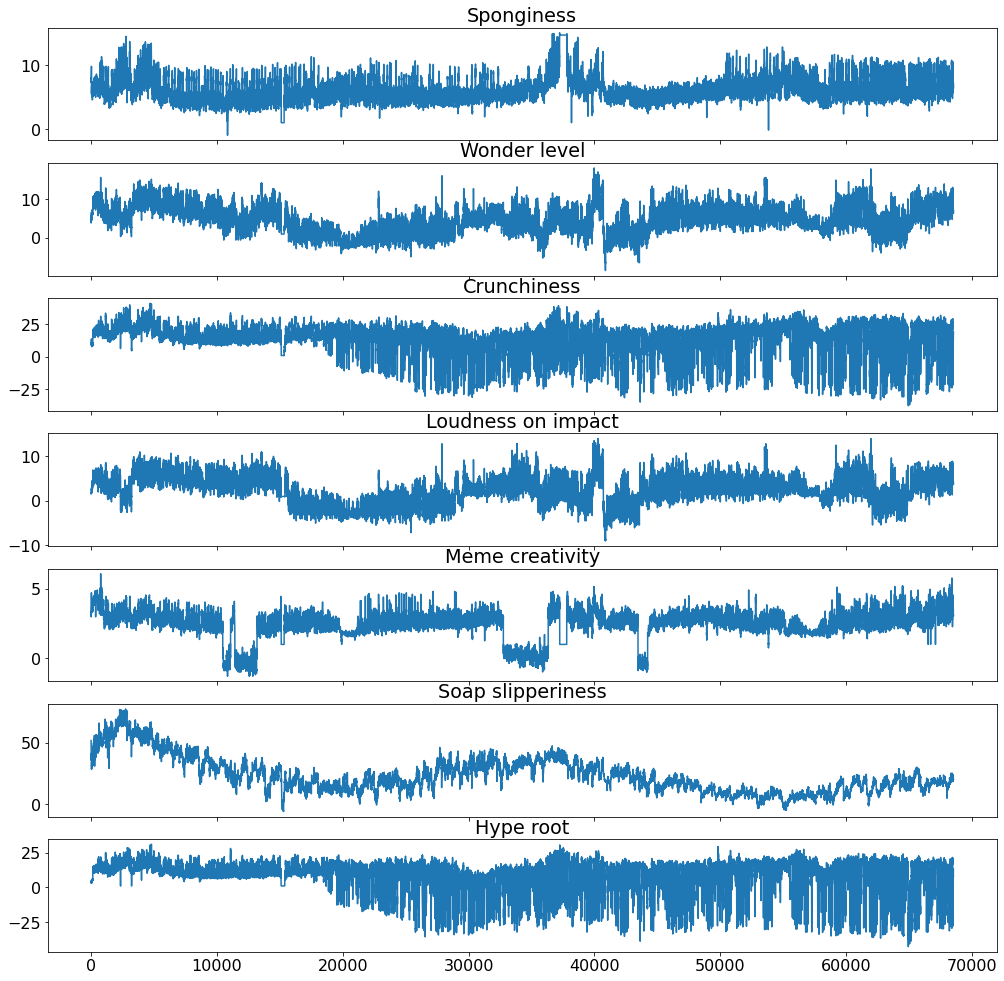

In [7]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

(60528, 7) (4000, 7) (4000, 7)


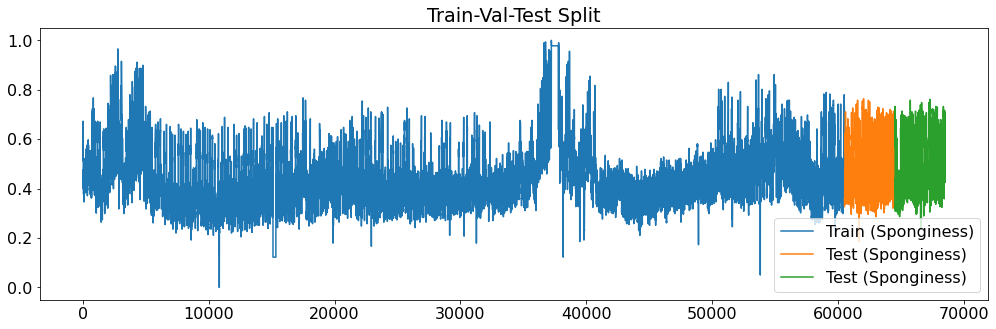

In [8]:
test_size = 4000
val_size = 4000
X_train_raw = dataset.iloc[:-test_size-val_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
X_val_raw = dataset.iloc[-test_size-val_size:-test_size]
print(X_train_raw.shape, X_val_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min(axis=0)
X_max = X_train_raw.max(axis=0)

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_val_raw = (X_val_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
plt.plot(X_val_raw.Sponginess, label='Test (Sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (Sponginess)')
plt.title('Train-Val-Test Split')
plt.legend()
plt.show()



In [9]:
if not os.path.exists("ModelSubmission"):
    os.makedirs("ModelSubmission")

with open(os.path.join('ModelSubmission', 'min_max.np'), 'wb') as f: 
    np.save(f, X_min)
    np.save(f, X_max)
    
print("X_min\n", X_min)
print("\nX_max\n", X_max)
print("\nX_max - X_min\n", X_max-X_min)

X_min
 Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -34.802881
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -38.816760
dtype: float64

X_max
 Sponginess            15.106680
Wonder level          18.122899
Crunchiness           41.138801
Loudness on impact    14.035980
Meme creativity        6.056360
Soap slipperiness     77.371620
Hype root             31.024420
dtype: float64

X_max - X_min
 Sponginess            16.078760
Wonder level          26.573279
Crunchiness           75.941682
Loudness on impact    23.064040
Meme creativity        7.332220
Soap slipperiness     83.378480
Hype root             69.841180
dtype: float64


In [10]:
window = 256
stride = 16

In [11]:
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 256, 7)

In [12]:
def build_sequences(df, target_labels=['Sponginess'], window=1020, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [13]:
target_labels = dataset.columns
telescope = 32

In [14]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_val, y_val = build_sequences(X_val_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((3774, 256, 7),
 (3774, 32, 7),
 (238, 256, 7),
 (238, 32, 7),
 (238, 256, 7),
 (238, 32, 7))

In [15]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

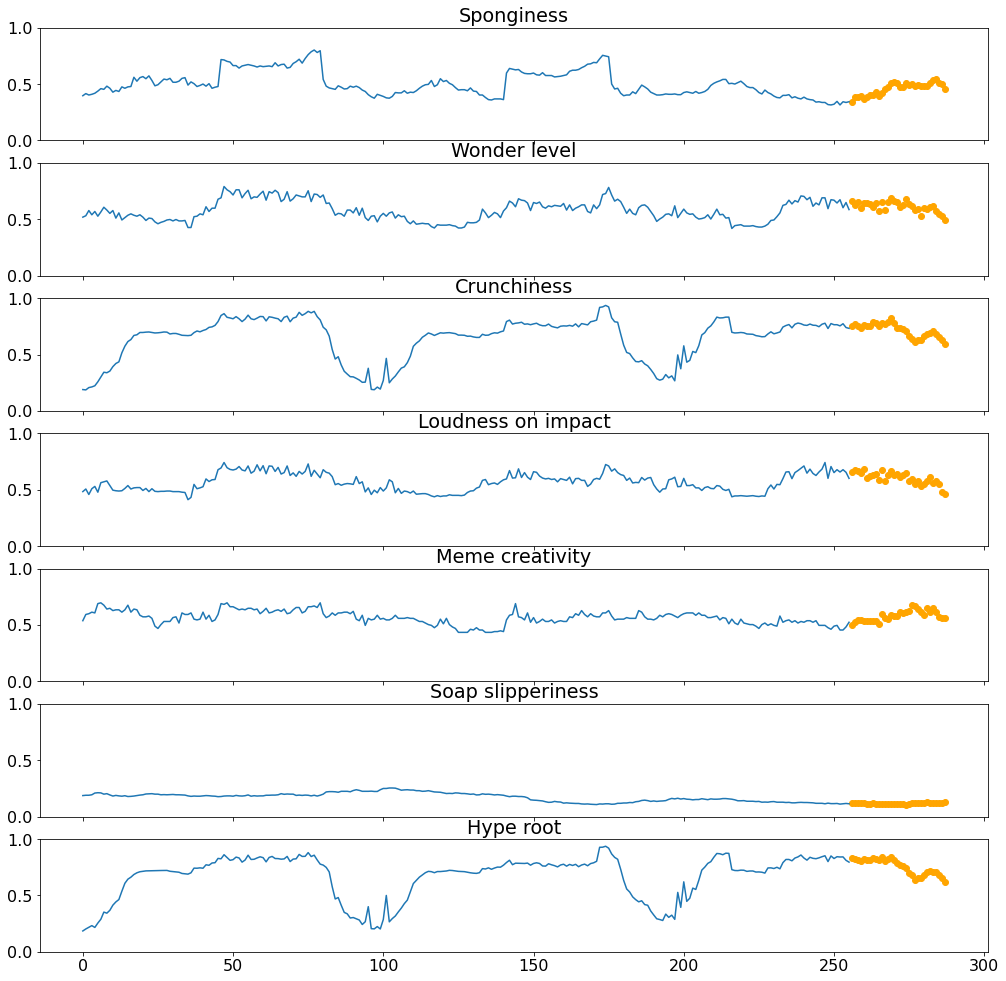

In [16]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [17]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 100




In [18]:
def LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    # filtro added
    lstm = tfkl.Conv1D(filters=14, kernel_size=7,  padding='same', kernel_initializer=glorot_uniform(seed=0))(input_layer)
    lstm = tfkl.Conv1D(filters=14, kernel_size=7,  padding='same', kernel_initializer=glorot_uniform(seed=0))(lstm)
    
    lstm = tfkl.LSTM(64)(lstm)
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='sigmoid')(lstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

2021-12-28 21:15:05.252549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 21:15:05.346273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 21:15:05.346992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 21:15:05.348156: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 256, 7)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 256, 14)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 14)           1386      
_________________________________________________________________
lstm (LSTM)                  (None, 64)                20224     
_________________________________________________________________
dense (Dense)                (None, 224)               14560     
_________________________________________________________________
reshape (Reshape)            (None, 32, 7)             0         
Total params: 36,870
Trainable params: 36,870
Non-trainable params: 0
_________________________________________________________

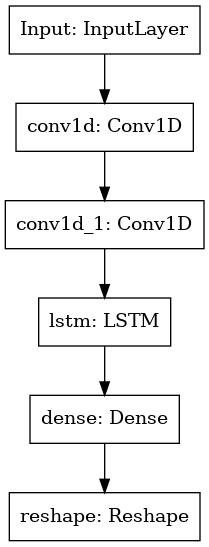

In [19]:
model = LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [20]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5),
        tf.keras.callbacks.ModelCheckpoint(os.path.join('ModelSubmission', 'best_weights.hdf5'), monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch')
    ]
).history

2021-12-28 21:15:09.075114: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-12-28 21:15:11.186185: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


59/59 [==============================] - 9s 19ms/step - loss: 0.0223 - mae: 0.1141 - val_loss: 0.0252 - val_mae: 0.1174

Epoch 00001: val_loss improved from inf to 0.02521, saving model to ModelSubmission/best_weights.hdf5
Epoch 2/100
59/59 [==============================] - 1s 14ms/step - loss: 0.0149 - mae: 0.0892 - val_loss: 0.0203 - val_mae: 0.1032

Epoch 00002: val_loss improved from 0.02521 to 0.02027, saving model to ModelSubmission/best_weights.hdf5
Epoch 3/100
59/59 [==============================] - 1s 13ms/step - loss: 0.0128 - mae: 0.0836 - val_loss: 0.0188 - val_mae: 0.0987

Epoch 00003: val_loss improved from 0.02027 to 0.01880, saving model to ModelSubmission/best_weights.hdf5
Epoch 4/100
59/59 [==============================] - 1s 12ms/step - loss: 0.0102 - mae: 0.0728 - val_loss: 0.0168 - val_mae: 0.0901

Epoch 00004: val_loss improved from 0.01880 to 0.01676, saving model to ModelSubmission/best_weights.hdf5
Epoch 5/100
59/59 [==============================] - 1s 12ms

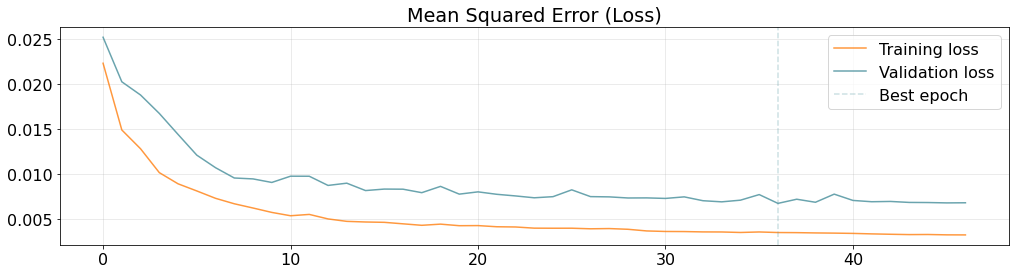

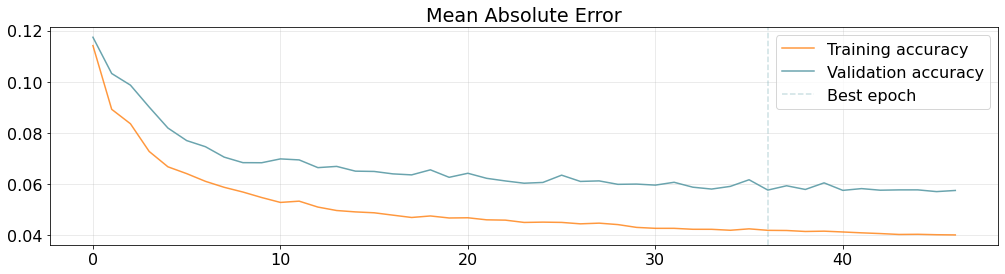

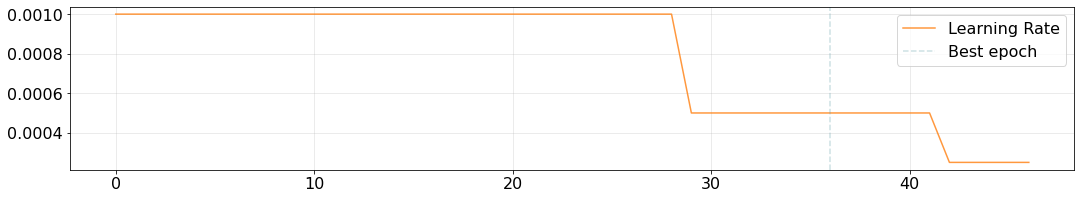

In [21]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [22]:
# model.save('DirectForecasting')
#model = tfk.models.load_model('DirectForecasting')

**TEST EVALUATION**

In [23]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(238, 32, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.00594627>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.05338197>)

In [24]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [25]:
#inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

**MULTIVARIATE FORECASTING (AUTOREGRESSION)**

In [26]:
reg_telescope = 864
X_val_reg, y_val_reg = build_sequences(X_val_raw, target_labels, window, stride, reg_telescope)
X_val_reg.shape, y_val_reg.shape

((186, 256, 7), (186, 864, 7))

In [27]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_val_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)
    
reg_predictions.shape

(186, 864, 7)

In [28]:
mean_squared_error = tfk.metrics.mse(y_val_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

for i in range(7):
    print (i, tfk.metrics.mse(y_val_reg[..., i].flatten(),reg_predictions[..., i].flatten()))

0 tf.Tensor(0.017215839, shape=(), dtype=float32)
1 tf.Tensor(0.012483166, shape=(), dtype=float32)
2 tf.Tensor(0.02229999, shape=(), dtype=float32)
3 tf.Tensor(0.013634861, shape=(), dtype=float32)
4 tf.Tensor(0.004843536, shape=(), dtype=float32)
5 tf.Tensor(0.04045391, shape=(), dtype=float32)
6 tf.Tensor(0.02198052, shape=(), dtype=float32)


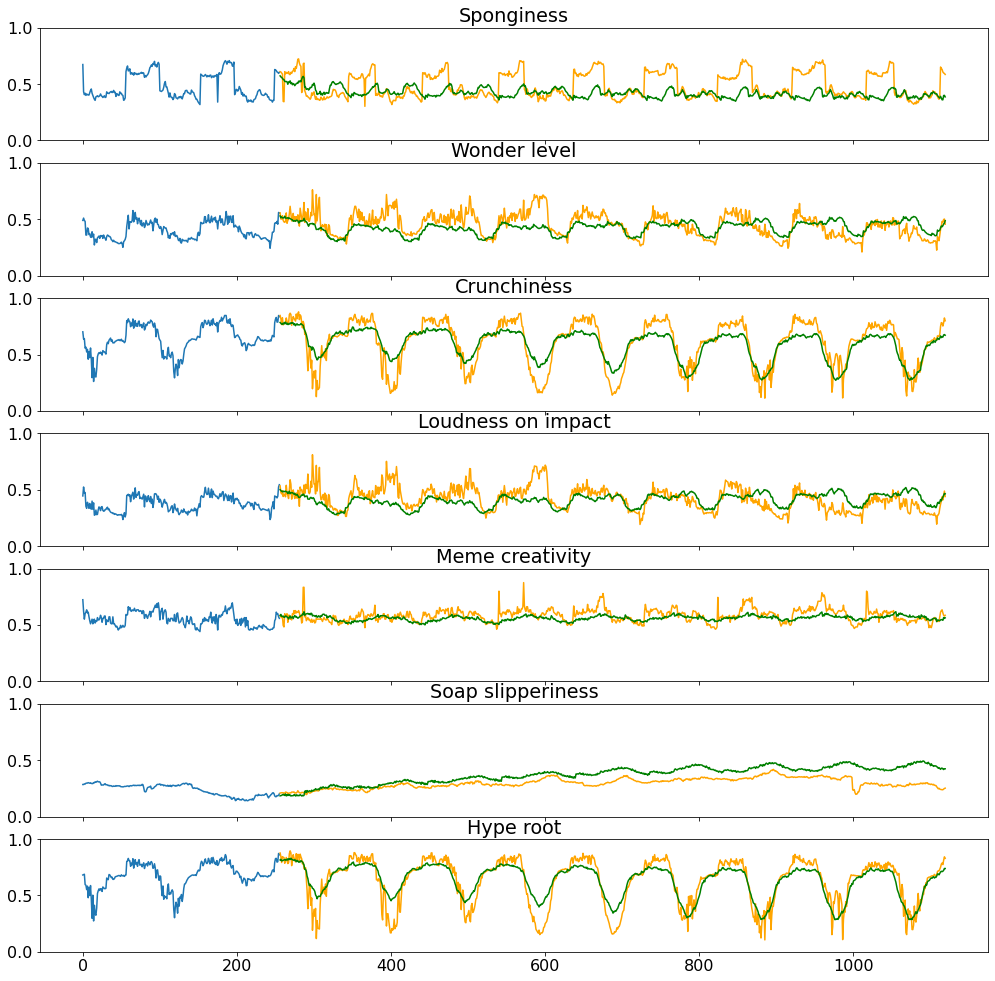

In [29]:
inspect_multivariate_prediction(X_val_reg, y_val_reg, reg_predictions, target_labels, reg_telescope)